<center><img src="https://i.imgur.com/2rGzuN5.jpg" width="750px" style="border:1px solid black"></center>

# Introduction

In this project, I will show how one can finetune EfficientNet-B7 to detect Melanoma (a variety of skin cancer) from images. This problem is important because fast and accurate automated diagnosis can help reduce burden on doctors and let them focus on curing patients. I will use the **Efficientnet Pytorch** package to get the pretrained EfficientNet-B7 model and **PyTorch XLA** to train the model on TPU. At the end, we will run inference on the test set and test the model's predictions on some sample images.

# Preparing the ground

In this section, we will prepare the ground to train and test the model by installing packages, setting hyperparameters, and loading the data.

## Set up PyTorch XLA

* We need to install a package called **PyTorch XLA** to take advantage of TPUs with PyTorch.
* Training on TPUs can be significantly faster than on CPUs or GPUs. So we will use TPUs for this project.

In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  42217      0 --:--:-- --:--:-- --:--:-- 42217


In [2]:
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
Found existing installation: torch 1.5.0
Uninstalling torch-1.5.0:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torch-1.5.0
Found existing installation: torchvision 0.6.0a0+82fd1c8
Uninstalling torchvision-0.6.0a0+82fd1c8:
  Successfully uninstalled torchvision-0.6.0a0+82fd1c8
Copying gs://tpu-pytorch/wheels/torch-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/90.2 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/121.3 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/2.1 MiB.                                      
Processing ./torch-nightly-cp37-cp37m-linux_x86_64.whl
ERROR: fastai 1.0.61 requires torchvision, which is no

## Install additional packages

* We will now install two other packages: **colored** and **efficientnet_pytorch**.
* **colored** helps add foreground colors to text output in Python to make training logs more readable.
* **efficientnet_pytorch** will help us load the EfficientNet-B7 architecture with the pretrained weights.

In [3]:
!export XLA_USE_BF16=1
!pip install -q colored
!pip install -q efficientnet_pytorch

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## Import necessary libraries

* Now, we import all the libraries we need.
* **colored, matplotlib, tqdm, and plotly** for visualization.
* **numpy, pandas, torch, torchvision, albumentations, and efficientnet_pytorch** for modelling.

In [4]:
import os
import gc
import cv2
import time
import numpy as np
import pandas as pd

from colored import fg, attr
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch import FloatTensor, LongTensor, DoubleTensor
from torch.utils.data.sampler import WeightedRandomSampler

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

from efficientnet_pytorch import EfficientNet
from albumentations import Normalize, VerticalFlip, HorizontalFlip, Compose

## Define key hyperparameters and paths

* Here we define the key hyperparameters: image height and width, train/val split, batch size, epochs, and LR.
* These hyperparameters can be tuned for performance, but runtime will change if you change **EPOCHS, H, or W.**

### Define hyperparameters and paths

In [6]:
W = 512
H = 512
B = 0.5
SPLIT = 0.8
SAMPLE = True
MU = [0.485, 0.456, 0.406]
SIGMA = [0.229, 0.224, 0.225]

EPOCHS = 2
LR = 1e-3, 1e-3
BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
MODEL = 'efficientnet-b7'
IMG_PATHS = ['../working/test',
             '../working/train_1',
             '../working/train_2']

### Get image path dictionary

In [7]:
PATH_DICT = {}
for folder_path in tqdm(IMG_PATHS):
    for img_path in os.listdir(folder_path):
        PATH_DICT[img_path] = folder_path + '/'

## Set random seeds

* The next step is to set the random seed for NumPy and PyTorch.
* Setting the random seed helps us keep training determinstic and ensure reproducible results.

In [8]:
np.random.seed(42)
torch.manual_seed(42)

## Load the training and testing metadata

* Now we need to load the training and testing metadata.
* These dataframes contain the image file names and targets which we need for training.

In [9]:
print(os.listdir('../input/siim-isic-melanoma-classification'))

['test.csv', 'train', 'jpeg', 'sample_submission.csv', 'train.csv', 'tfrecords', 'test']


In [10]:
test_df = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')
train_df = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')

In [11]:
test_df.head(10)

image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity
5  ISIC_0074618  IP_4438996    male        50.0               lower extremity
6  ISIC_0076801  IP_3110660    male        45.0               upper extremity
7  ISIC_0077586  IP_8578442    male        50.0               lower extremity
8  ISIC_0082004  IP_0817448  female        45.0                         torso
9  ISIC_0082785  IP_3634181    male        65.0               lower extremity

In [12]:
train_df.head(10)

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   
5  ISIC_0074311  IP_2950485  female        40.0               lower extremity   
6  ISIC_0074542  IP_4698288    male        25.0               lower extremity   
7  ISIC_0075663  IP_6017204  female        35.0                         torso   
8  ISIC_0075914  IP_7622888    male        30.0                         torso   
9  ISIC_0076262  IP_5075533  female        50.0               lower extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0  
5   unknown           benign       0  
6   unknown           benign       0  
7   unknown           benign       0  
8   unknown           benign       0  
9   unknown           benign       0

In [13]:
sfn = lambda x: "🔎 " + str(x)
fs = (fg('#7efc79'), attr('reset'))
gs = (fg('#fac3c3'), attr('reset'))

for column in train_df.columns[[7, 2, 6, 4, 5]]:
    column_string = ("%s" + column + "%s 🎯\n") % gs
    column_values = set(train_df[column].apply(sfn))
    column_values = "\n".join(sorted(column_values, key=len))
    hyphens = ("%s" + ''.join(['-']*len(column)) + "\n%s") % gs
    print(hyphens + column_string + hyphens + "\n" + ("%s" + column_values + "\n%s") % fs)

------
target 🎯
------

🔎 0
🔎 1

---
sex 🎯
---

🔎 nan
🔎 male
🔎 female

----------------
benign_malignant 🎯
----------------

🔎 benign
🔎 malignant

-----------------------------
anatom_site_general_challenge 🎯
-----------------------------

🔎 nan
🔎 torso
🔎 head/neck
🔎 palms/soles
🔎 oral/genital
🔎 lower extremity
🔎 upper extremity

---------
diagnosis 🎯
---------

🔎 nevus
🔎 unknown
🔎 melanoma
🔎 lentigo NOS
🔎 solar lentigo
🔎 cafe-au-lait macule
🔎 lichenoid keratosis
🔎 seborrheic keratosis
🔎 atypical melanocytic proliferation



From the graph above, we can see that the proportion of males (in green) under "melanoma" is much higher than under "healthy". This might suggest that most patients suffering from melanoma in this dataset are males.

## Display sample images

* Now, I will show few sample images from the test directory to get an idea of what these skin images look like.

In [19]:
def display_images(num):
    sq_num = np.sqrt(num)
    assert sq_num == int(sq_num)

    sq_num = int(sq_num)
    image_ids = os.listdir(IMG_PATHS[0])
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(20, 20))

    for i in range(sq_num):
        for j in range(sq_num):
            idx = i*sq_num + j
            ax[i, j].axis('off')
            img = cv2.imread(IMG_PATHS[0] + '/' + image_ids[idx])
            ax[i, j].imshow(img); ax[i, j].set_title('Test Image {}'.format(idx), fontsize=12)

    plt.show()

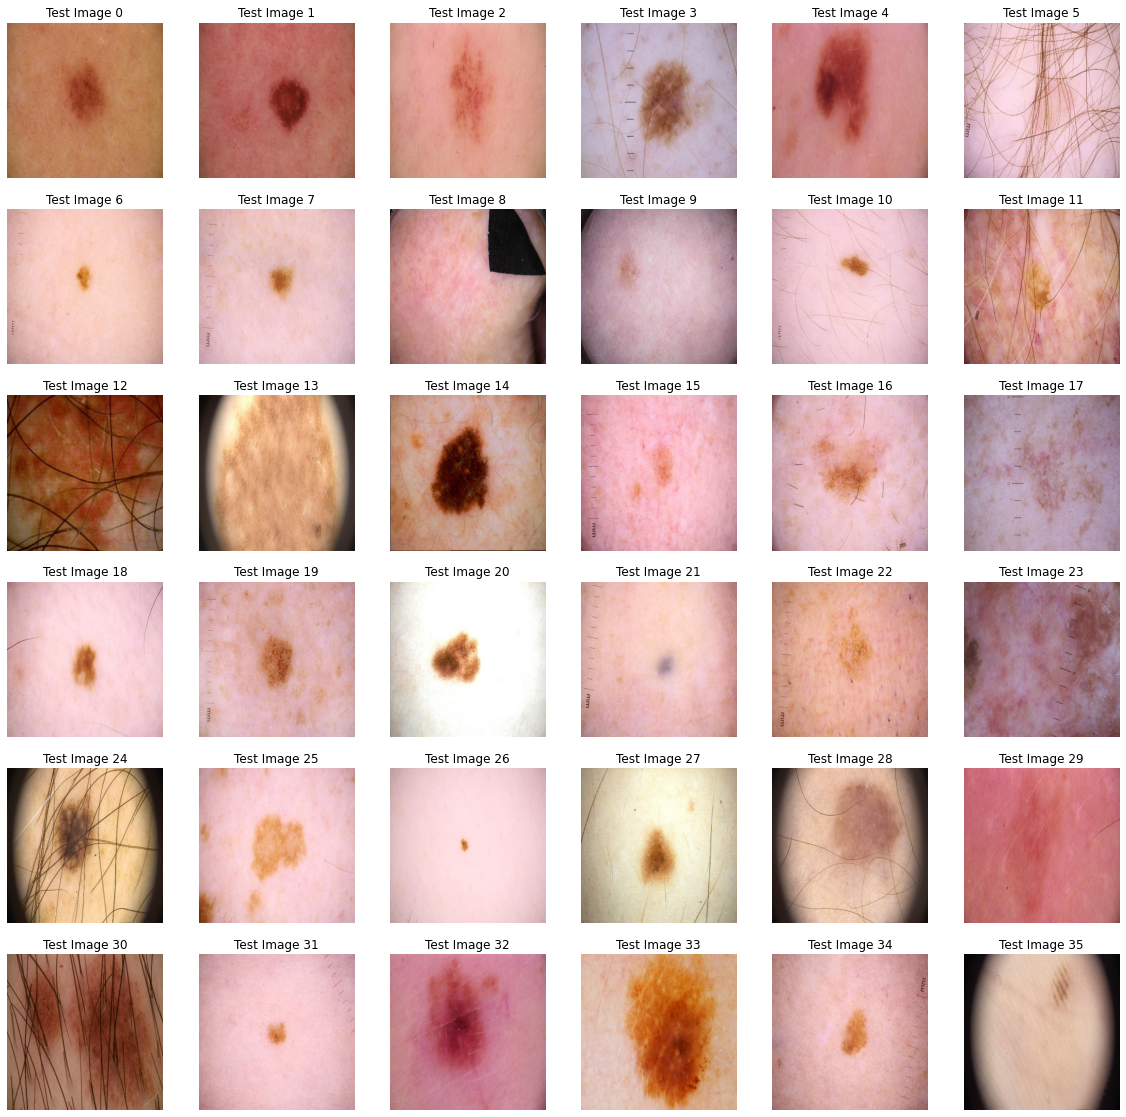

In [20]:
display_images(36)

<center><img src="https://i.imgur.com/ZwkZIbN.jpg" width="600px"></center>

# Modeling

* Now since we understand the dataset better, it is time to build a machine learning pipeline to solve this problem.
* I will use a classic image classification pipeline with image augmentation and a pretrained EfficientNet model.

## Define PyTorch dataset

* The first step is to build a PyTorch dataset to generate data for our model.
* A PyTorch dataset has three fundamental functions: <code>init</code>, <code>len</code>, and <code>getitem</code>.
* The <code>init</code> function initializes all the components required for data loading (image path, transforms, etc).
* The <code>len</code> function simply returns the length of the dataset. This indicates the number of retrievable samples.
* The <code>getitem</code> function returns a data point at a given index <code>idx</code>. The actual logic is written in this function.
* The <code>getitem</code> function does 3 things: gets the target, loads the image, resizes it to (512, 512), and randomly flips.

In [21]:
def to_tensor(data):
    return [FloatTensor(point) for point in data]

def set_image_transformations(dataset, aug):
    norm = Normalize(mean=MU, std=SIGMA, p=1)
    vflip, hflip = VerticalFlip(p=0.5), HorizontalFlip(p=0.5)
    dataset.transformation = Compose([norm, vflip, hflip]) if aug else norm

class SIIMDataset(Dataset):
    def __init__(self, df, aug, targ, ids):
        set_image_transformations(self, aug)
        self.df, self.targ, self.aug, self.image_ids = df, targ, aug, ids

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, i):
        image_id = self.image_ids[i]
        target = [self.df.target[i]] if self.targ else 0
        image = cv2.imread(PATH_DICT[image_id] + image_id)
        return to_tensor([self.transformation(image=image)['image'], target])

## Define EfficientNet-B7 model

* Now we define the actual model which we are going to train.
* The <code>CancerNet</code> model uses an **EfficientNet-B7** backbone with a **(Pooling + Dense)** head for classification.

In [22]:
def GlobalAveragePooling(x):
    return x.mean(axis=-1).mean(axis=-1)

class CancerNet(nn.Module):
    def __init__(self, features):
        super(CancerNet, self).__init__()
        self.avgpool = GlobalAveragePooling
        self.dense_output = nn.Linear(features, 1)
        self.efn = EfficientNet.from_pretrained(MODEL)
        
    def forward(self, x):
        x = x.view(-1, 3, H, W)
        x = self.efn.extract_features(x)
        return self.dense_output(self.avgpool(x))

## Define binary cross entropy and accuracy

* Next, we define our loss function (**binary cross entropy**) and evaluation metric (**accuracy**).

In [23]:
def bce(y_true, y_pred):
    return nn.BCEWithLogitsLoss()(y_pred, y_true)

def acc(y_true, y_pred):
    y_true = y_true.squeeze()
    y_pred = nn.Sigmoid()(y_pred).squeeze()
    return (y_true == torch.round(y_pred)).float().sum()/len(y_true)

## Define helper function for training logs

* Now we define a simple helper function to produce training logs (with foreground colors).

In [24]:
def print_metric(data, batch, epoch, start, end, metric, typ):
    t = typ, metric, "%s", data, "%s"
    if typ == "Train": pre = "BATCH %s" + str(batch-1) + "%s  "
    if typ == "Val": pre = "\nEPOCH %s" + str(epoch+1) + "%s  "
    time = np.round(end - start, 1); time = "Time: %s{}%s s".format(time)
    fonts = [(fg(211), attr('reset')), (fg(212), attr('reset')), (fg(213), attr('reset'))]
    print(pre % fonts[0] + "{} {}: {}{}{}".format(*t) % fonts[1] + "  " + time % fonts[2])

## Split train/val (80/20)

* We now split the data into training and validation sets (train: 80%, val: 20%).

In [25]:
split = int(SPLIT*len(train_df))
train_df, val_df = train_df.loc[:split], train_df.loc[split:]
train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

## Define PyTorch dataloaders, model, and optimizer

* Next we define the PyTorch dataloader (for loading the train and val data).
* We also define our model (<code>CancerNet</code>) and optimizer (<code>ADAM</code>) for training.
* We use <code>WeightedRandomSampler</code> to fix data imbalance (with weight <code>B</code> for 1s)

### Define sampling weights

In [26]:
C = np.array([B, (1 - B)])*2
ones = len(train_df.query('target == 1'))
zeros = len(train_df.query('target == 0'))

weightage_fn = {0: C[1]/zeros, 1: C[0]/ones}
weights = [weightage_fn[target] for target in train_df.target]

### Define PyTorch datasets

In [27]:
length = len(train_df)
val_ids = val_df.image_name.apply(lambda x: x + '.jpg')
train_ids = train_df.image_name.apply(lambda x: x + '.jpg')

val_set = SIIMDataset(val_df, False, True, val_ids)
train_set = SIIMDataset(train_df, True, True, train_ids)

### Define sampling procedure and DataLoader

In [28]:
train_sampler = WeightedRandomSampler(weights, length)
if_sample, if_shuffle = (train_sampler, False), (None, True)
sample_fn = lambda is_sample, sampler: if_sample if is_sample else if_shuffle

sampler, shuffler = sample_fn(SAMPLE, train_sampler)
val_loader = DataLoader(val_set, VAL_BATCH_SIZE, shuffle=False)
train_loader = DataLoader(train_set, BATCH_SIZE, sampler=sampler, shuffle=shuffler)

### Define model and optimizer

In [29]:
device = xm.xla_device()
network = CancerNet(features=2560).to(device)
optimizer = Adam([{'params': network.efn.parameters(), 'lr': LR[0]},
                  {'params': network.dense_output.parameters(), 'lr': LR[1]}])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7


## Train the model on one TPU core

* Now, we train the model on one TPU core.
* First, we do a **training loop**, where we train the model with back-prop to adjust the parameters.
* Second, we do a **validation loop**, to check the model's performance on unseen data after each epoch.
* The training loop uses **forward-prop and back-prop**, while the validation loop uses **only forward-prop.**
* We use the <code>torch.no_grad()</code> flag for the validation loop as no gradients are needed for forward-prop.

In [30]:
print("STARTING TRAINING ...\n")

start = time.time()
train_batches = len(train_loader) - 1

for epoch in range(EPOCHS):
    fonts = (fg(48), attr('reset'))
    print(("EPOCH %s" + str(epoch+1) + "%s") % fonts)
    
    batch = 1
    network.train()
    for train_batch in train_loader:
        train_img, train_targ = train_batch
        train_targ = train_targ.view(-1, 1)
        train_img, train_targ = train_img.to(device), train_targ.to(device)
        
        if batch >= train_batches: break
        train_preds = network.forward(train_img)
        train_acc = acc(train_targ, train_preds)
        train_loss = bce(train_targ, train_preds)
            
        optimizer.zero_grad()
        train_loss.backward()
        xm.optimizer_step(optimizer, barrier=True)
            
        end = time.time()
        batch = batch + 1
        accuracy = np.round(train_acc.item(), 3)
        print_metric(accuracy, batch, 0, start, end, metric="acc", typ="Train")
            
    network.eval()
    val_loss, val_acc, val_points = 0, 0, 0
        
    with torch.no_grad():
        for val_batch in tqdm(val_loader):
            val_img, val_targ = val_batch
            val_targ = val_targ.view(-1, 1)
            val_img, val_targ = val_img.to(device), val_targ.to(device)

            val_points += len(val_targ)
            val_preds = network.forward(val_img)
            val_acc += acc(val_targ, val_preds).item()*len(val_preds)
            val_loss += bce(val_targ, val_preds).item()*len(val_preds)
        
    end = time.time()
    val_acc /= val_points
    val_loss /= val_points
    accuracy = np.round(val_acc, 3)
    print_metric(accuracy, 0, epoch, start, end, metric="acc", typ="Val")
    
    print("")

print("ENDING TRAINING ...")

STARTING TRAINING ...

EPOCH 1
BATCH 1  Train acc: 0.562  Time: 147.9 s
BATCH 2  Train acc: 0.625  Time: 312.6 s
BATCH 3  Train acc: 0.625  Time: 317.6 s
BATCH 4  Train acc: 0.625  Time: 322.5 s
BATCH 5  Train acc: 0.844  Time: 327.4 s
BATCH 6  Train acc: 0.812  Time: 332.2 s
BATCH 7  Train acc: 0.75  Time: 337.0 s
BATCH 8  Train acc: 0.75  Time: 342.1 s
BATCH 9  Train acc: 0.688  Time: 346.9 s
BATCH 10  Train acc: 0.719  Time: 351.7 s
BATCH 11  Train acc: 0.562  Time: 356.5 s
BATCH 12  Train acc: 0.688  Time: 361.3 s
BATCH 13  Train acc: 0.625  Time: 366.1 s
BATCH 14  Train acc: 0.656  Time: 370.9 s
BATCH 15  Train acc: 0.594  Time: 375.6 s
BATCH 16  Train acc: 0.719  Time: 380.4 s
BATCH 17  Train acc: 0.719  Time: 385.4 s
BATCH 18  Train acc: 0.594  Time: 390.2 s
BATCH 19  Train acc: 0.781  Time: 394.9 s
BATCH 20  Train acc: 0.719  Time: 399.7 s
BATCH 21  Train acc: 0.75  Time: 404.5 s
BATCH 22  Train acc: 0.719  Time: 409.3 s
BATCH 23  Train acc: 0.844  Time: 414.0 s
BATCH 24  Train



EPOCH 1  Val acc: 0.861  Time: 4581.1 s

EPOCH 2
BATCH 1  Train acc: 0.875  Time: 4723.1 s
BATCH 2  Train acc: 0.844  Time: 4728.2 s
BATCH 3  Train acc: 0.875  Time: 4733.0 s
BATCH 4  Train acc: 0.781  Time: 4737.8 s
BATCH 5  Train acc: 0.75  Time: 4742.6 s
BATCH 6  Train acc: 0.906  Time: 4747.4 s
BATCH 7  Train acc: 0.875  Time: 4752.1 s
BATCH 8  Train acc: 0.844  Time: 4757.0 s
BATCH 9  Train acc: 0.906  Time: 4761.8 s
BATCH 10  Train acc: 0.844  Time: 4766.5 s
BATCH 11  Train acc: 0.812  Time: 4771.3 s
BATCH 12  Train acc: 0.875  Time: 4776.1 s
BATCH 13  Train acc: 0.875  Time: 4780.9 s
BATCH 14  Train acc: 0.844  Time: 4785.7 s
BATCH 15  Train acc: 0.812  Time: 4790.4 s
BATCH 16  Train acc: 0.844  Time: 4795.2 s
BATCH 17  Train acc: 0.906  Time: 4800.0 s
BATCH 18  Train acc: 0.656  Time: 4804.8 s
BATCH 19  Train acc: 0.844  Time: 4809.6 s
BATCH 20  Train acc: 0.812  Time: 4814.4 s
BATCH 21  Train acc: 0.75  Time: 4819.2 s
BATCH 22  Train acc: 0.875  Time: 4823.9 s
BATCH 23  Trai



EPOCH 2  Val acc: 0.847  Time: 8985.9 s

ENDING TRAINING ...


## Run inference on the test data

* Next I will run inference on the test data and store the test predictions in a list.
* These predictions are logits and will be converted to probabilities later using <code>sigmoid</code>.

In [31]:
test_ids = test_df.image_name.apply(lambda x: x + '.jpg')

In [32]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

test_set = SIIMDataset(test_df, False, False, test_ids)
test_loader = tqdm(DataLoader(test_set, VAL_BATCH_SIZE, shuffle=False))

network.eval()
test_preds = []
with torch.no_grad():
    for test_batch in test_loader:
        test_img, _ = test_batch
        test_img = test_img.to(device)
        test_preds.extend(network.forward(test_img).squeeze().detach().cpu().numpy())

## Visualize sample test predictions

* Now since the model is trained, we will visualize predictions made on unseen test images.

In [33]:
def display_preds(num):
    sq_num = np.sqrt(num)
    assert sq_num == int(sq_num)

    sq_num = int(sq_num)
    image_ids = os.listdir(IMG_PATHS[0])
    few_preds = sigmoid(np.array(test_preds[:num]))
    pred_dict = {0: '"No Melanoma"', 1: '"Melanoma"'}
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(20, 20))
    norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1)

    for i in range(sq_num):
        for j in range(sq_num):
            idx = i*sq_num + j
            ax[i, j].axis('off')
            pred = few_preds[idx]
            img = cv2.imread(IMG_PATHS[0] + '/' + image_ids[idx])
            ax[i, j].imshow(img); ax[i, j].set_title('Prediction: {}'.format(pred_dict[round(pred.item())]), fontsize=12)

    plt.show()

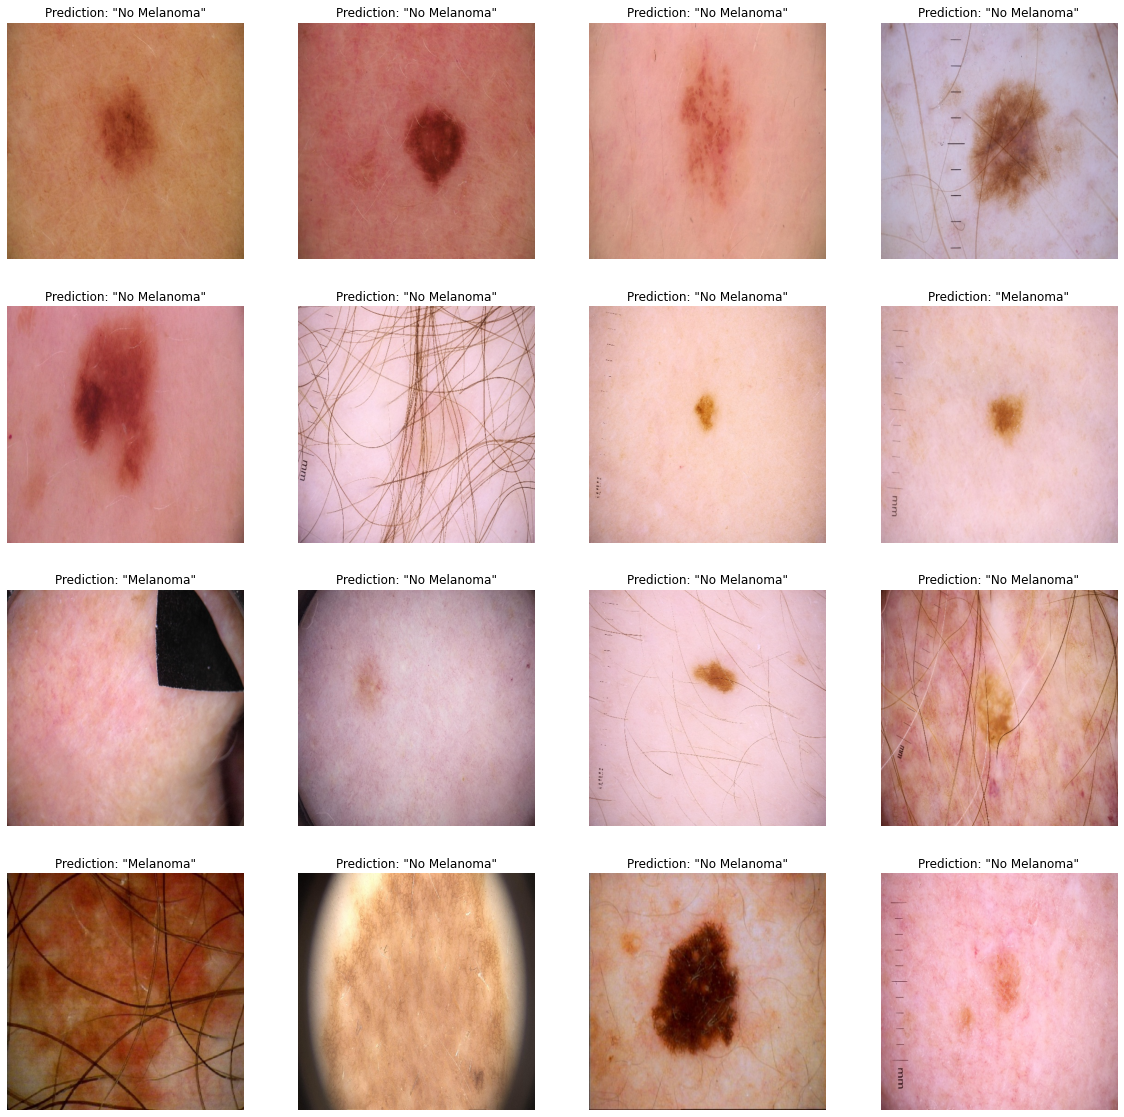

In [34]:
display_preds(16)

## Sigmoid the logits and generate submission file

* Now we apply the sigmoid function to all the logits and prepare the final submission file.

In [35]:
path = '../input/siim-isic-melanoma-classification/'
sample_submission = pd.read_csv(path + 'sample_submission.csv')

In [36]:
sample_submission.target = sigmoid(np.array(test_preds))

In [37]:
sample_submission.head()

image_name    target
0  ISIC_0052060  0.002594
1  ISIC_0052349  0.000098
2  ISIC_0058510  0.000121
3  ISIC_0073313  0.000300
4  ISIC_0073502  0.127897

In [38]:
sample_submission.to_csv('submission.csv', index=False)

# Takeaways

* Training is very fast on TPUs and should be used when possible.
* Pretrained models like EfficientNet-B7 can generalize effectively to new tasks.